<a href="https://colab.research.google.com/github/IsaacFigNewton/DisCoFuzz/blob/main/DisCoFuzz_WF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Config

## Import

In [1]:
from typing import Callable, Dict, List, Tuple, Set
import math
import numpy as np
import random
import nltk

nltk.download('wordnet')
nltk.download('framenet-17')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
from nltk.corpus import framenet as fn
from nltk.corpus import stopwords

import spacy

import pandas as pd

import scipy.stats as stats
from scipy.special import expit, logit

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

import tensorflow as tf

import ot

from sentence_transformers import SentenceTransformer

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz import (
    LemmaVectorizer,
    FourierPDF,
    FuzzyFourierSetMixin,
    FourierFuzzifier,
    FuzzyFourierTensorTransformer,
    SpacyDependencyComposer
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading framenet-17: Package 'framenet-17' not found
[nltk_data]     in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Config

In [2]:
stop_words = stopwords.words("english")
all_synsets = list(wn.all_synsets())

In [3]:
wn_dict = {
    'synset': list(),
    'lemmas': list(),
    'antonyms': list(),
    'gloss': list(),
    "cleaned_gloss": list(),
}

for s in all_synsets:
  synset_lemma = s.name().split(".")[0]
  lemmas = s.lemmas()
  antonyms = list()
  for lemma in lemmas:
    antonyms += list(lemma.antonyms())
  if len(lemmas) > 1 and len(antonyms) > 0:
    wn_dict['synset'].append(s.name())
    wn_dict['lemmas'].append([l.name() for l in lemmas if l.name() != synset_lemma])
    wn_dict['antonyms'].append([a.name() for a in antonyms])
    wn_dict['gloss'].append(s.definition())
    cleaned_gloss = " ".join([t for t in s.definition().split(" ") if t not in stop_words])
    wn_dict['cleaned_gloss'].append(cleaned_gloss.replace("_", " "))

wn_df = pd.DataFrame.from_dict(wn_dict)
wn_df.head()

,synset,lemmas,antonyms,gloss,cleaned_gloss
0,abaxial.a.01,[dorsal],[adaxial],facing away from the axis of an organ or organism,facing away axis organ organism
1,adaxial.a.01,[ventral],[abaxial],nearest to or facing toward the axis of an org...,nearest facing toward axis organ organism
2,abducent.a.01,[abducting],[adducent],especially of muscles; drawing away from the m...,especially muscles; drawing away midline body ...
3,adducent.a.01,"[adductive, adducting]",[abducent],especially of muscles; bringing together or dr...,especially muscles; bringing together drawing ...
4,relative.a.01,[comparative],[absolute],estimated by comparison; not absolute or complete,estimated comparison; absolute complete


In [4]:
wn_df = wn_df.sample(frac=0.1).reset_index(drop=True)
sample_size = len(wn_df)
print(f'Number of synsets: {len(wn_df)}')

Number of synsets: 267


In [5]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
spacy_model = spacy.load("en_core_web_sm")
lemma_vectorizer = LemmaVectorizer()
fuzzifier = FuzzyFourierTensorTransformer()

# npsd-ot seems to do best for the fuzzy intersection+mean composition model
sim_metric = "npsd-ot"
fuzzifier.fuzzifier.kernel_size

8

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

# Vectorize and fuzzify wn_df entries

In [7]:
def vectorize(strings: List[str]) -> tf.Tensor:
  vects = embedding_model.encode(strings)
  normalized_vects = (vects - np.min(vects))/(np.max(vects) - np.min(vects))
  return tf.convert_to_tensor(normalized_vects)

In [8]:
composers = {
    s: SpacyDependencyComposer(
        strategy=s,
        spacy_model=spacy_model,
        lemma_vectorizer=lemma_vectorizer,
        fuzzifier=fuzzifier
    )
    for s in STRATEGIES
}

gloss_vect_fuzzy_cols = {
    s: f"gloss_fuzzy_{s}"
    for s in STRATEGIES
}

In [9]:
# get mean embedding for synset lemmas
wn_df['synset_vect'] = wn_df['synset'].apply(lambda x: vectorize(x.split(".")[0].replace("_", " ")))
wn_df['gloss_vect'] = wn_df['gloss'].apply(vectorize)
wn_df['lemmas_vect'] = wn_df['lemmas'].apply(vectorize)

In [10]:
# get fuzzified synset embedding
wn_df['synset_vect_fuzzy'] = wn_df['synset_vect'].apply(lambda x: fuzzifier.fuzzify(x))
# get compositional embeddings for glosses using different strategies
for s, composer in composers.items():
  print(f"Getting gloss embedding with {s} approach...")
  wn_df[gloss_vect_fuzzy_cols[s]] = wn_df["cleaned_gloss"].apply(composer)

Getting gloss embedding with None approach...
Getting gloss embedding with mean approach...
Getting gloss embedding with intersection+mean approach...
Getting gloss embedding with intersection+union approach...
Getting gloss embedding with intersection+intersection approach...
Getting gloss embedding with selective_intersection+mean approach...
Getting gloss embedding with selective_intersection+union approach...
Getting gloss embedding with selective_intersection+intersection+mean approach...


# Test fuzzy embedding operators

In [11]:
# pick a random row in wn_df
row_idx = random.choice(wn_df.index)
# get the fourier tensors for the first lemma's fuzzy vect
fuzzy_vects = wn_df.loc[row_idx, 'synset_vect_fuzzy']
intersected_components = fuzzifier.fuzzifier.intersection(fuzzy_vects[0], fuzzy_vects[1])

In [12]:
print(f"Area under first component of synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[0])}")
print(f"Area under second component of synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[1])}")
print(f"Area under intersection of first 2 components of synset {row_idx}: {fuzzifier.fuzzifier._integrate(intersected_components)}")

Area under first component of synset 240: (1.0000001192092896-7.2177499532699585e-09j)
Area under second component of synset 240: (1+3.725290298461914e-09j)
Area under intersection of first 2 components of synset 240: (1.0000001192092896-1.932494342327118e-08j)


# Evaluate Inner Product (Similarity) Preservation

## Config

In [13]:
sim = tf.keras.losses.CosineSimilarity(
    axis=-1,
    reduction='sum_over_batch_size',
    name='cosine_similarity'
)
def cosine_similarity(a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
  return -1*sim(a, b).numpy()

In [14]:
random_pairing_indices = [
    tuple(random.sample(range(len(wn_df)), 2))
    for i in range(sample_size)
]

sim_eval_dict = {
    "syn_gloss_cos_sim": [],
    "is_related": [],
}

for s in STRATEGIES:
  # for comparing inner product of fuzzy synset similarities to related glosses
  sim_eval_dict[f"syn_{gloss_vect_fuzzy_cols[s]}"] = []

## Fuzzy space similarities

In [15]:
# extend classes
sim_eval_dict["is_related"] = [1, 0] * len(random_pairing_indices)
# syn-gloss cosine similarities
for a, b in random_pairing_indices:
  sim_eval_dict["syn_gloss_cos_sim"].extend([
      cosine_similarity(
          wn_df.loc[a, 'synset_vect'],
          wn_df.loc[a, 'gloss_vect']
      ),
      cosine_similarity(
          wn_df.loc[a, 'synset_vect'],
          wn_df.loc[b, 'gloss_vect']
      )
  ])

In [16]:
# syn-gloss custom fuzzy similarities
import numpy as np # Ensure numpy is imported for np.nan

for s in STRATEGIES:
  print(f"Evaluating similarities for gloss embeddings with {s} composition strategy...")

  for a, b in random_pairing_indices:
    synset_vect_fuzzy = wn_df.loc[a, 'synset_vect_fuzzy']
    fuzzy_col = gloss_vect_fuzzy_cols[s]

    gloss_a_fuzzy = wn_df.loc[a, fuzzy_col]
    gloss_b_fuzzy = wn_df.loc[b, fuzzy_col]

    sim_a = np.nan # Default to NaN
    sim_b = np.nan # Default to NaN

    # Only calculate similarity if the gloss embedding is not None
    if gloss_a_fuzzy is not None:
        sim_a = fuzzifier.similarity(
            synset_vect_fuzzy,
            gloss_a_fuzzy,
            sim_metric
        )

    # Only calculate similarity if the gloss embedding is not None
    if gloss_b_fuzzy is not None:
        sim_b = fuzzifier.similarity(
            synset_vect_fuzzy,
            gloss_b_fuzzy,
            sim_metric
        )

    sim_eval_dict[f"syn_{fuzzy_col}"].extend([sim_a, sim_b])

Evaluating similarities for gloss embeddings with None composition strategy...
Evaluating similarities for gloss embeddings with mean composition strategy...
Evaluating similarities for gloss embeddings with intersection+mean composition strategy...
Evaluating similarities for gloss embeddings with intersection+union composition strategy...
Evaluating similarities for gloss embeddings with intersection+intersection composition strategy...
Evaluating similarities for gloss embeddings with selective_intersection+mean composition strategy...
Evaluating similarities for gloss embeddings with selective_intersection+union composition strategy...
Evaluating similarities for gloss embeddings with selective_intersection+intersection+mean composition strategy...


In [17]:
sim_eval_df = pd.DataFrame.from_dict(sim_eval_dict)
# normalize similarities
for col in sim_eval_df.columns:
  sim_eval_df[col] = (sim_eval_df[col] - sim_eval_df[col].min()) / (sim_eval_df[col].max() - sim_eval_df[col].min())
sim_eval_df.head()

,syn_gloss_cos_sim,is_related,syn_gloss_fuzzy_None,syn_gloss_fuzzy_mean,syn_gloss_fuzzy_intersection+mean,syn_gloss_fuzzy_intersection+union,syn_gloss_fuzzy_intersection+intersection,syn_gloss_fuzzy_selective_intersection+mean,syn_gloss_fuzzy_selective_intersection+union,syn_gloss_fuzzy_selective_intersection+intersection+mean
0,0.493530,1.0,0.624222,0.236017,0.018227,0.012731,0.012731,0.010468,0.011548,0.010531
1,0.492645,0.0,0.571520,0.430008,0.020875,0.010504,0.010504,0.923713,1.000000,0.923713
2,0.482573,1.0,0.692300,1.000000,0.029925,0.030552,0.030552,1.000000,1.000000,1.000000
3,0.186144,0.0,0.684995,0.157924,0.014841,0.033089,0.033089,0.006018,0.009188,0.010037
4,0.583576,1.0,0.285927,0.191856,0.031839,0.032494,0.032494,0.891839,1.000000,0.891839


In [18]:
sim_eval_df.describe()

,syn_gloss_cos_sim,is_related,syn_gloss_fuzzy_None,syn_gloss_fuzzy_mean,syn_gloss_fuzzy_intersection+mean,syn_gloss_fuzzy_intersection+union,syn_gloss_fuzzy_intersection+intersection,syn_gloss_fuzzy_selective_intersection+mean,syn_gloss_fuzzy_selective_intersection+union,syn_gloss_fuzzy_selective_intersection+intersection+mean
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,0.504876,0.500000,0.549367,0.587009,0.051550,0.051816,0.051816,0.411210,0.423325,0.411415
std,0.193416,0.500469,0.166088,0.363339,0.168233,0.168300,0.168300,0.447780,0.485456,0.447595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.369020,0.000000,0.428888,0.243740,0.013204,0.012053,0.012053,0.010552,0.011063,0.010289
50%,0.494031,0.500000,0.557079,0.462087,0.022023,0.017302,0.017302,0.024809,0.031541,0.031406
75%,0.628704,1.000000,0.657656,1.000000,0.031368,0.032835,0.032835,0.923476,1.000000,0.923476
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
for c in sim_eval_df.columns:
  print(f"Number of np.nans: {np.sum(sim_eval_df[c].isna())}")

Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 0


## Visualize embedding similarities

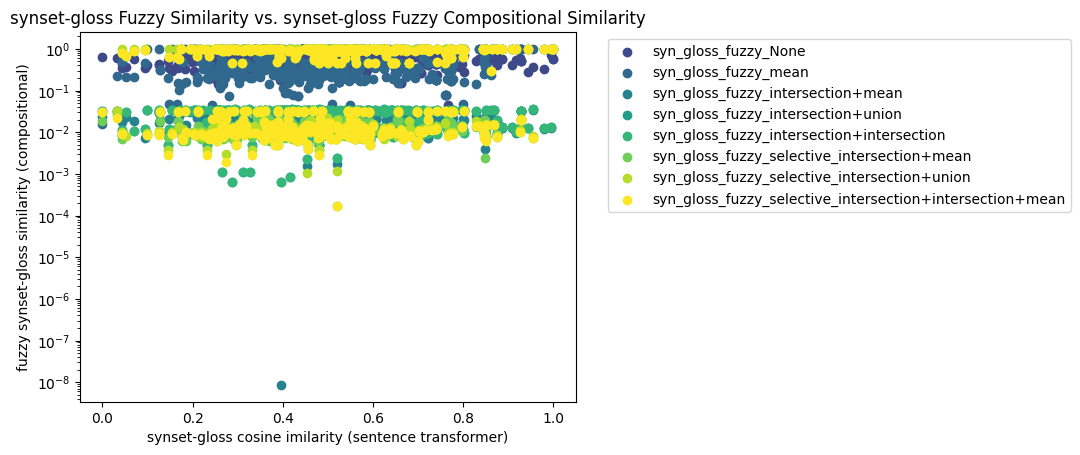

In [20]:
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(sim_eval_df.columns)))
for i, col in enumerate(sim_eval_df.columns):
  if col in ["syn_gloss_cos_sim", "is_related"]:
    continue
  plt.scatter(
      x=sim_eval_df["syn_gloss_cos_sim"],
      y=sim_eval_df[col],
      color=colors[i],
      label=col
  )

plt.xlabel("synset-gloss cosine imilarity (sentence transformer)")
plt.ylabel("fuzzy synset-gloss similarity (compositional)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale("log")
plt.title("synset-gloss Fuzzy Similarity vs. synset-gloss Fuzzy Compositional Similarity")
plt.show()

In [21]:
sim_eval_df.columns

Index(['syn_gloss_cos_sim', 'is_related', 'syn_gloss_fuzzy_None',
       'syn_gloss_fuzzy_mean', 'syn_gloss_fuzzy_intersection+mean',
       'syn_gloss_fuzzy_intersection+union',
       'syn_gloss_fuzzy_intersection+intersection',
       'syn_gloss_fuzzy_selective_intersection+mean',
       'syn_gloss_fuzzy_selective_intersection+union',
       'syn_gloss_fuzzy_selective_intersection+intersection+mean'],
      dtype='object')

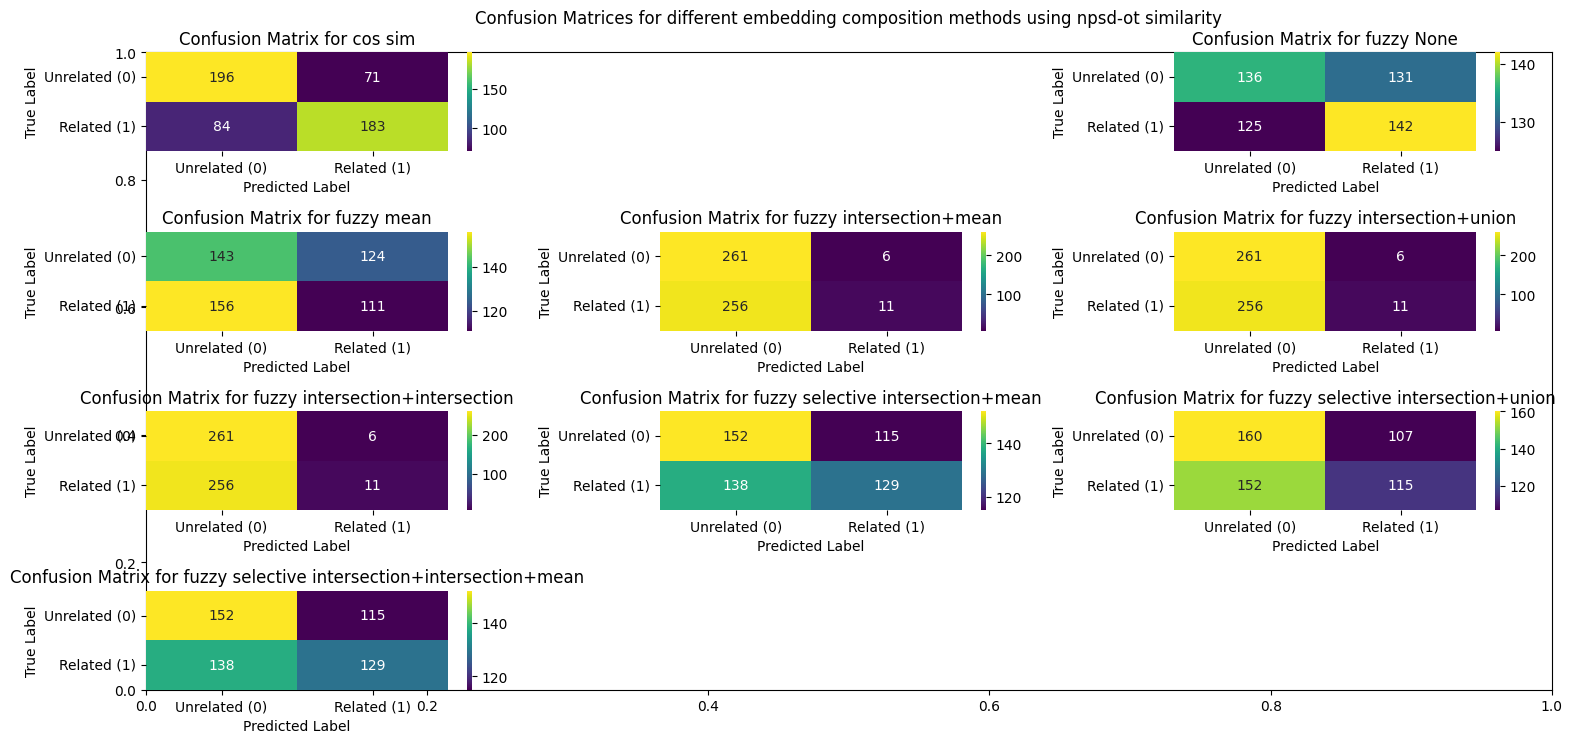

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(16, 8))

plt.title(f"Confusion Matrices for different embedding composition methods using {sim_metric} similarity\n")
for i, col in enumerate(sim_eval_df.columns):
    if col in ["is_related"]:
      continue

    # Calculate confusion matrix
    cm = confusion_matrix(
        sim_eval_df['is_related'],
         (sim_eval_df[col] >= sim_eval_df[col].mean()).astype(int)
    )

    # Plot confusion matrix
    plt.subplot(4, 3, i+1)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=['Unrelated (0)', 'Related (1)'],
        yticklabels=['Unrelated (0)', 'Related (1)']
    )
    plt.title(f'Confusion Matrix for {col.replace("syn_gloss_", "").replace("_", " ")}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Stat analysis

## Correlation coefficients

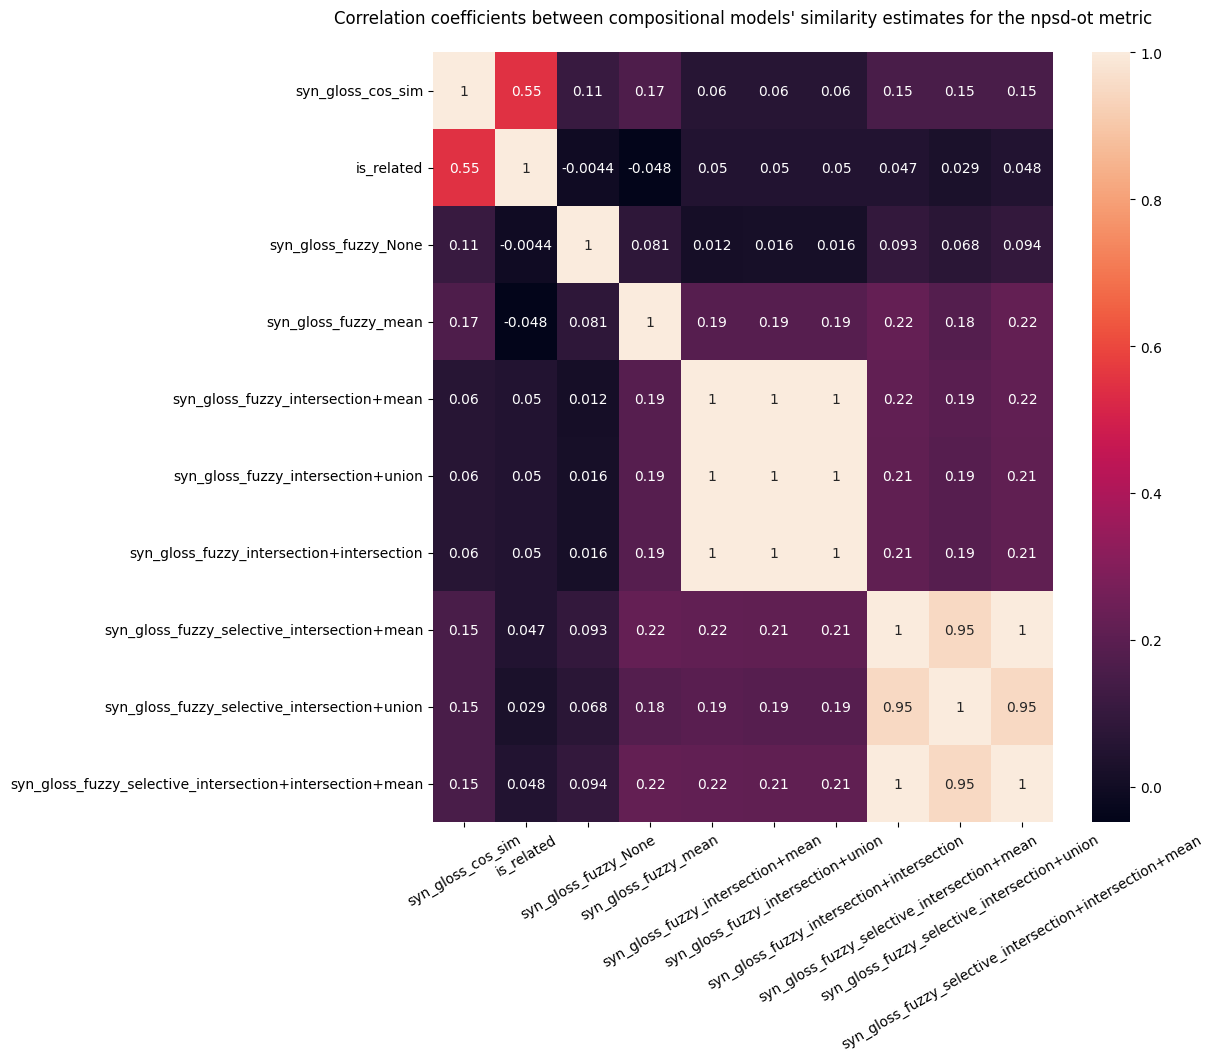

In [23]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(sim_eval_df.corr(), annot=True)
ax.tick_params(axis='x', labelrotation=30)
plt.title(f"Correlation coefficients between compositional models' similarity estimates for the {sim_metric} metric\n")
plt.show()

## Comparing composition STRATEGIES' differentiation capability between related and unrelated glosses

In [24]:
sep_eval_dict = {
    "mean_cos_similarity": [],
    "cos_separability": []
}
for s in STRATEGIES:
  sep_eval_dict[f"separability_{s}"] = []

In [25]:
for i in range(0, len(sim_eval_df), 2):
  # cosine similarity
  sep_eval_dict["mean_cos_similarity"].append(sim_eval_df.loc[i, "syn_gloss_cos_sim"]/2 + sim_eval_df.loc[i+1, "syn_gloss_cos_sim"]/2)
  sep_eval_dict["cos_separability"].append(sim_eval_df.loc[i, "syn_gloss_cos_sim"] - sim_eval_df.loc[i+1, "syn_gloss_cos_sim"])
  for s in STRATEGIES:
    strat = f"syn_{gloss_vect_fuzzy_cols[s]}"
    sep_eval_dict[f"separability_{s}"] = sim_eval_df.loc[i, strat] - sim_eval_df.loc[i+1, strat]

sep_eval_df = pd.DataFrame.from_dict(sep_eval_dict)

## Visuals

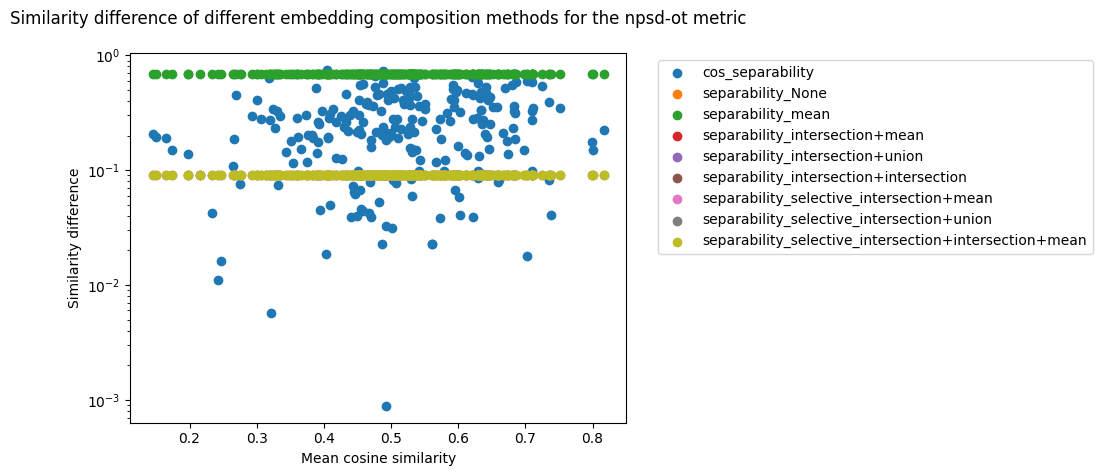

In [26]:
for c in sep_eval_df.columns:
  if c in ["mean_cos_similarity"]:
    continue
  plt.scatter(
      x=sep_eval_df["mean_cos_similarity"],
      y=sep_eval_df[c],
      label=c
  )
plt.xlabel("Mean cosine similarity")
plt.ylabel("Similarity difference")
# plt.xscale("log")
plt.yscale("log")
plt.legend(
    [c for c in sep_eval_df.columns if c not in ["mean_cos_similarity"]],
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title(f"Similarity difference of different embedding composition methods for the {sim_metric} metric\n")
plt.show()

del sep_eval_df["mean_cos_similarity"]

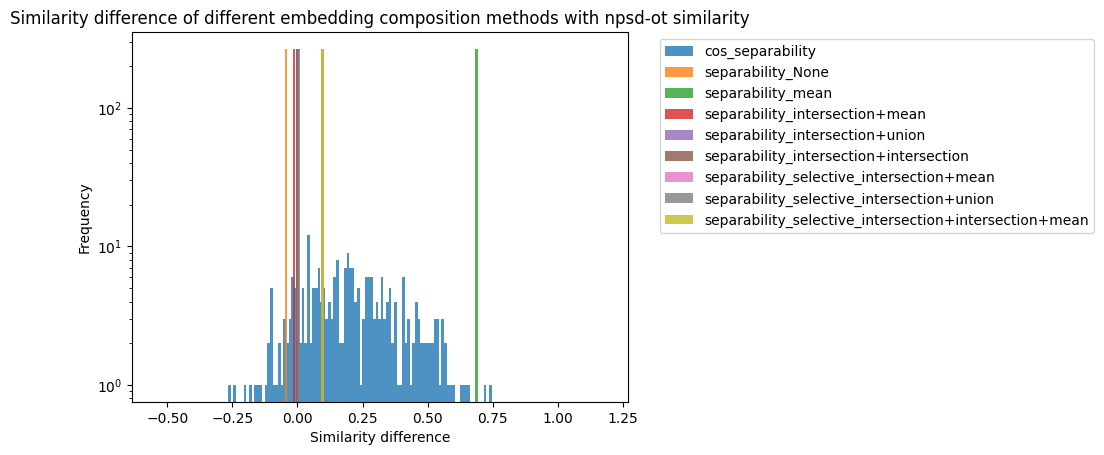

In [27]:
for col in sep_eval_df.columns:
  plt.hist(
      sep_eval_df[col],
      bins=100,
      alpha=0.8,
      # range=(-.01, .01)
  )

plt.xlabel("Similarity difference")
plt.ylabel("Frequency")
# plt.xscale("log")
plt.yscale("log")
plt.legend(
    sep_eval_df.columns,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title(f"Similarity difference of different embedding composition methods with {sim_metric} similarity")
plt.show()

## Significance tests for separability

In [28]:
print("p-value for separability of...")
for col in sep_eval_df.columns:
  # get probability mean(eval_df["separability_fuzzy"]) > 0
  p = stats.ttest_1samp(
      sep_eval_df[col],
      0,
      alternative="greater"
  ).pvalue
  print(f"\t{col} > 0:{'\t'*(10 - len(col)//7)}{p}")

p-value for separability of...
	cos_separability > 0:								3.0073217209501617e-46
	separability_None > 0:								1.0
	separability_mean > 0:								0.0
	separability_intersection+mean > 0:						1.0
	separability_intersection+union > 0:						1.0
	separability_intersection+intersection > 0:					1.0
	separability_selective_intersection+mean > 0:					0.0
	separability_selective_intersection+union > 0:					1.0
	separability_selective_intersection+intersection+mean > 0:			0.0


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
